# Домашнее задание №7: «Ядра SVM» [\[link\]](http://mit.spbau.ru/sewiki/images/c/cc/ML17-Homework7.pdf)

## Funcs for data

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


TEST_SIZE = 0.3


def gen_data(n=1000, m=2):
    X, Y_raw = make_classification(n, m, n_redundant=0)
    Y = 2 * Y_raw - 1
    return X, Y


X_train, X_test, Y_train, Y_test = train_test_split(*gen_data(), test_size=TEST_SIZE)

## Useful funcs

In [2]:
import numpy as np
import cvxopt as cvx
from functools import reduce


def stack(matricies):
    return reduce(lambda a, y: np.vstack((a, y)),
                  (reduce(lambda a, x: np.hstack((a, x)), row) for row in matricies))


def Z(n, m=None):
    return np.zeros((n, m if m else n))


def O(n, m=None):
    return Z(n, m) + 1


def E(n):
    return np.eye(n)


def makem(matricies):
    return cvx.matrix(stack(matricies), tc='d')


def makesm(matricies):
    return cvx.sparse(makem(matricies))


def sign(A):
    return 2 * (A >= 0) - 1

## LinearSVM

In [3]:
cvx.solvers.options['show_progress'] = False


class LinearSVM:
    def __init__(self, *, C):
        self.C = C
        self.w, self.w0 = None, None
        self.ind_support = None

    def fit(self, X, Y):
        n, m = X.shape
        Y = Y[None].T
        P = makesm([[E(m), Z(m, n + 1)], [Z(n + 1, m), Z(n + 1)]])
        q = makem([[Z(m + 1, 1)], [self.C * O(n, 1)]])
        G = makesm([[Z(n, m), Z(n, 1), -E(n)], [-Y * X, -Y, -E(n)]])
        h = makem([[Z(n, 1)], [-O(n, 1)]])
        x = cvx.solvers.qp(P, q, G, h)['x']
        self.w, self.w0 = np.array(x[:m])[:, 0], x[m]
        ksi = np.array(x[m + 1:])[:, 0]
        self.ind_support = np.where(np.isclose(Y[:, 0] * self.decision_function(X), 1 - ksi))[0]

    def decision_function(self, X):
        return X @ self.w + self.w0

    def predict(self, X):
        return sign(self.decision_function(X))

In [4]:
lsvm = LinearSVM(C=2)
lsvm.fit(X_train, Y_train)
(lsvm.predict(X_test) == Y_test).sum() / len(Y_test)

0.90666666666666662

## KernelSVM

In [5]:
def linear_kernel(X1, X2):
    return X1 @ X2.T


def poly_kernel(degree):
    def poly_kernel(X1, X2):
        return (linear_kernel(X1, X2) + 1) ** degree
    return poly_kernel


def gauss_kernel(sigma):
    def gauss_kernel(X1, X2):
        return np.exp(-sigma * ((X1[:, np.newaxis] - X2) ** 2).sum(axis=2))
    return gauss_kernel

In [6]:
class KernelSVM:
    def __init__(self, *, C, kernel=linear_kernel):
        self.C = C
        self.kernel = kernel
        self.a, self.w0 = None, None
        self.X_train, self.Y_train = None, None
        self.ind_support = None
    
    def fit(self, X, Y):
        n, m = X.shape
        Y = Y[None].T
        K = self.kernel(X, X)
        P = makesm([[Y * Y.T * K]])
        q = makem([[-O(n, 1)]])
        G = makesm([[E(n)], [-E(n)]])
        h = makem([[self.C * O(n, 1)], [Z(n, 1)]])
        A = makesm([[Y.T]])
        b = makem([[Z(1, 1)]])
        x = cvx.solvers.qp(P, q, G, h, A, b)['x']
        self.a = np.array(x)[:, 0]
        self.ind_support = np.where(self.a > 0)[0]
        self.w0 = (Y[self.ind_support] - (K[self.ind_support] @ (self.a * Y[:, 0]))).mean()
        self.X_train, self.Y_train = X, Y[:, 0]
    
    def decision_function(self, X):
        return self.kernel(X, self.X_train) @ (self.a * self.Y_train) + self.w0
    
    def predict(self, X):
        return sign(self.decision_function(X))

In [7]:
ksvm = KernelSVM(C=2, kernel=linear_kernel)
ksvm.fit(X_train, Y_train)
(ksvm.predict(X_test) == Y_test).sum() / len(Y_test)

0.90666666666666662

## Visualization

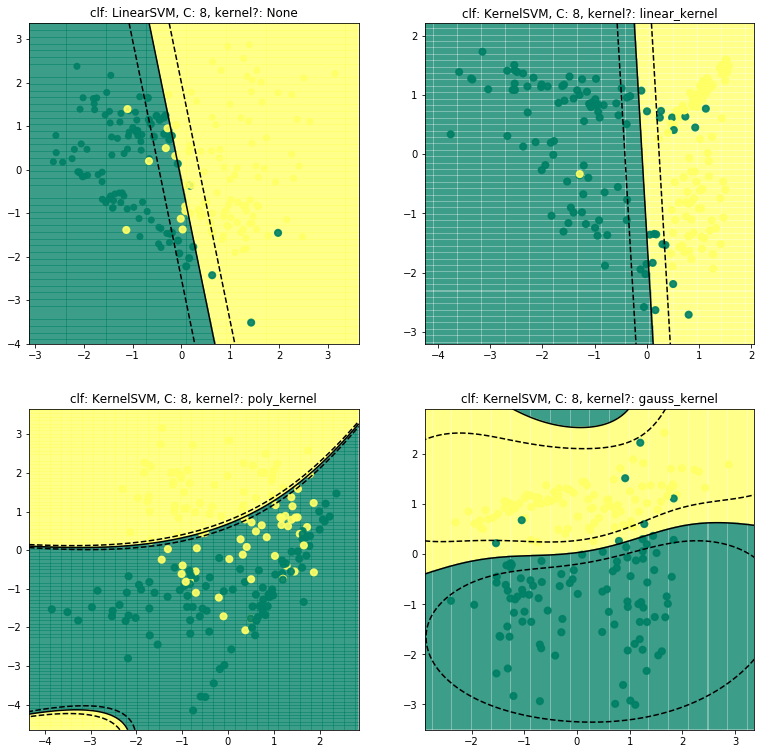

In [8]:
%matplotlib inline
from visualize import visualize
from itertools import chain, product
import matplotlib.pyplot as plt


Cs = [8]
degrees = [3]
sigmas = [.25]
kernels = chain((linear_kernel,),
                (poly_kernel(degree) for degree in degrees),
                (gauss_kernel(sigma) for sigma in sigmas))
clfs = list(chain((LinearSVM(C=C) for C in Cs), 
                  (KernelSVM(C=C, kernel=kernel) for C, kernel in product(Cs, kernels))))


figs, axes = plt.subplots((len(clfs) // 2) + len(clfs) % 2, 2)
figs.set_figheight(13)
figs.set_figwidth(13)

for clf, axis in zip(clfs, axes.ravel()):
    visualize(clf, *gen_data(n=200), axis)

## Q&A

* **Что можно сказать про влияние параметров на классификацию?**

	Размер $C$ пропорционален силе регуляризации. Маленькая сигма в ядре гауса действует лучше (оптимально где-то с $0.1$). Увеличение степени влияет отрицательно (оптимально где-то с $2$ или $3$).